In [1]:
import tifffile as tf
from scipy import ndimage, signal
import numpy as np
import numpy.polynomial.polynomial as P
import os
import argparse
import glob
import math
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import unionfind as UF

In [30]:
dst = '../clean/'
filesrc = '../clean/2014SBa_R1_T25/diagnostic/'
anchors0 = np.loadtxt(filesrc+'anchors0.csv', dtype='float', delimiter=',')
anchors1 = np.loadtxt(filesrc+'anchors1.csv', dtype='float', delimiter=',')
loc_maxa = np.loadtxt(filesrc+'local_maxima.csv', dtype='int', delimiter=',')

In [3]:
print(anchors0)
np.median(anchors0, axis=0)

[[0.42127812 0.89151776 0.97873578]
 [0.41665776 0.89672195 0.98096351]
 [0.36633908 0.89029442 0.98132344]
 [0.32785737 0.89706199 0.98288911]
 [0.405002   0.89184912 0.7857574 ]
 [0.39713986 0.89060346 0.97856686]
 [0.41955106 0.88437953 0.97911448]
 [0.44451408 0.89049952 0.97719151]]


array([0.41082988, 0.89106061, 0.97892513])

In [4]:
print(anchors1)
np.median(anchors1, axis=0)

[[0.40142511 0.88833882 0.97851891]
 [0.38349343 0.8913214  0.98054669]
 [0.29540031 0.87870077 0.98007845]
 [0.33013476 0.89357678 0.9828119 ]
 [0.39223308 0.89008912 0.78145724]
 [0.39690414 0.89135496 0.97959379]
 [0.39836823 0.88129507 0.97959102]
 [0.39687663 0.88136359 0.97565932]]


array([0.39455485, 0.88921397, 0.97959241])

In [5]:
y = np.median(loc_maxa, axis=0)
anchors = np.median(anchors1, axis = 0)
print(y)
print(anchors)

[ 40.5 172.  223.5]
[0.39455485 0.88921397 0.97959241]


## Load scans

In [57]:
walnut_batch = sorted(glob.glob('../raw/*/'))
bidx = 7
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))
bname = walnut_batch[bidx].split('/')[-2]
wdst = dst + bname + '/'
print(bname)

SelectD_R9_T1


In [58]:
widx = -1
print(walnut_files[widx])
img = tf.imread(walnut_files[widx])//256
img = img.astype(np.uint8)

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

hist0,bins = np.histogram(img, bins=2**(img.dtype.itemsize*8),range=(0,2**(img.dtype.itemsize*8)))
fhist = ndimage.median_filter(hist0, size=5, mode='constant', cval=0)
cumul = np.cumsum(fhist)

../raw/SelectD_R9_T1/006.tif
006


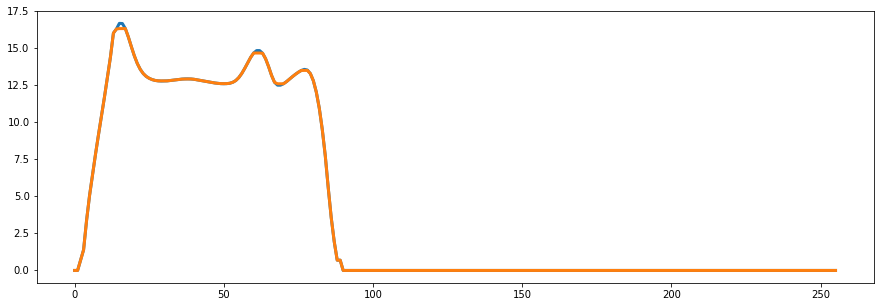

In [59]:
lw=3
fig = plt.figure(figsize=(15,5))
plt.plot(np.log(hist0 +1), lw=lw);
plt.plot(np.log(fhist+1), lw=lw);

In [60]:
tot = cumul[-1]
x = np.zeros(len(anchors))
for i,a in enumerate(anchors):
    for j,s in enumerate(cumul):
        if s>a*tot:
            print('[ {} , {:03d} ]:\t {} > {:.3f}*{}\t = {:.0f}'.format(i,j,s,a,tot,a*tot))
            #print('[',i,',',j,']: ',s,'>',a,'*',tot,'=',a*tot)
            break
    if j > 0:
        x[i] = j-1+(a*tot-cumul[j-1])/(cumul[j]-cumul[j-1])
    else:
        x[i] = 0
print('\n',x)

[ 0 , 016 ]:	 47997682 > 0.395*111158269	 = 43858034
[ 1 , 063 ]:	 101041665 > 0.889*111158269	 = 98843485
[ 2 , 077 ]:	 109230523 > 0.980*111158269	 = 108889796

 [15.66313647 62.05431493 76.5335629 ]


In [61]:
npz = P.Polynomial.fit(x,y,2)
print(npz.convert().coef)

[7.63372836 1.91247778 0.01186494]


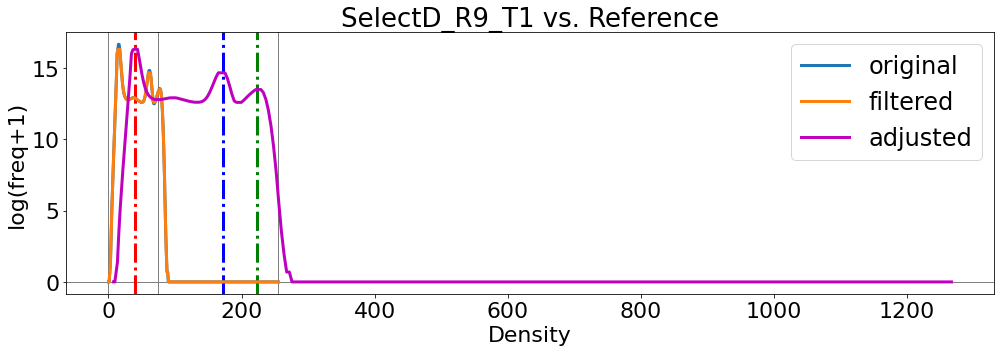

In [62]:
fig, ax = plt.subplots(figsize=(14,5))
lw = 3

ax.axhline(0, c='gray', lw=1)
ax.axvline(y[0], ls='-.', lw=lw, c='r')
ax.axvline(y[1], ls='-.', lw=lw, c='b')
ax.axvline(y[2], ls='-.', lw=lw, c='g')
ax.axvline(0, c='gray', lw=1)
ax.axvline(255, c='gray', lw=1)
ax.axvline(75, c='gray', lw=1)

ax.plot(bins[:-1], np.log(hist0+1), lw=lw, label = 'original')
ax.plot(bins[:-1], np.log(fhist+1), lw=lw, label = 'filtered')
ax.plot(npz(bins[:-1]), np.log(fhist+1), lw=lw, label = 'adjusted', c='m')

ax.set_xlabel("Density", fontsize=22)
ax.set_ylabel("log(freq+1)", fontsize=22)
ax.set_title(bname + ' vs. Reference', fontsize=26)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)
plt.tight_layout()

In [79]:
def normalize_density(img, npz):
    resol = 2**(img.dtype.itemsize*8)
    rescale = np.round(npz(np.arange(resol, dtype=img.dtype)))
    rescale[rescale < 0] = 0
    rescale[rescale > resol - 1] = resol - 1
    rescale.astype(img.dtype)

    with np.nditer(img, flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = rescale[x]

    return img

def get_largest_element(comp):
    labels,num = ndimage.label(comp, structure=ndimage.generate_binary_structure(comp.ndim, 1))
    print(num,'components')
    hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
    argsort_hist = np.argsort(hist)[::-1]
    print(np.sort(hist)[::-1][:20])

    j = 0
    i = argsort_hist[j]
    mask = labels==i+1
    box0 = comp.copy()
    box0[~mask] = 0
    
    return box0

def fill_component(comp, x=True, y=True, z=True):
    rcomp = comp.copy()
    rcomp[rcomp > 0] = 1

    if x:
        for k in range(rcomp.shape[0]):
            rcomp[k,:,:] = ndimage.binary_fill_holes(rcomp[k,:,:])
        print('Closed X')
    if y:
        for k in range(rcomp.shape[1]):
            rcomp[:,k,:] = ndimage.binary_fill_holes(rcomp[:,k,:])
        print('Closed Y')
    if z:
        for k in range(rcomp.shape[2]):
            rcomp[:,:,k] = ndimage.binary_fill_holes(rcomp[:,:,k])
        print('Closed Z')

    return rcomp

def clean_zeroes(img, pad=2):
    dim = img.ndim
    orig_size = img.size

    cero = np.arange(2*dim)

    for k in range(dim):
        ceros = np.all(img == 0, axis = (k, (k+1)%dim))

        for i in range(len(ceros)):
            if(~ceros[i]):
                break
        for j in range(len(ceros)-1, 0, -1):
            if(~ceros[j]):
                break
        cero[k] = i
        cero[k+dim] = j+1
    for i in range(dim):
        cero[i] -= 2
    for i in range(dim, len(cero)):
        cero[i] += 2
    cero[cero < 0] = 0
    img = img[cero[1]:cero[4], cero[2]:cero[5], cero[0]:cero[3]]

    print(round(100-100*img.size/orig_size),'% reduction from input')

    return img, cero

def collapse_dimensions(img):
    snaps = []
    for i in range(img.ndim):
        snaps.append(np.sum(img, axis=i))
    return snaps

def collapse_dimensions_max(img):
    snaps = []
    for i in range(img.ndim):
        snaps.append(np.max(img, axis=i))
    return snaps

def plot_collapse_dimensions(snaps, bname='bname', tissue='tissue', display=False, writefig=False, dst='./'):
    fig, ax = plt.subplots(1,len(snaps),figsize=(6*len(snaps),6))
    for i in range(len(snaps)):
        ax[i].imshow(snaps[i], cmap='inferno', origin='lower');
    plt.suptitle(bname + ' ' + tissue + ' collapse', fontsize=20);
    plt.tight_layout()

    if writefig:
        filename = dst + bname + '_' + '_'.join(tissue.split(' ')) + '.jpg'
        plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight');
        if not display:
            plt.close();

In [64]:
aimg = img.copy()
aimg = normalize_density(aimg, npz)

In [65]:
thr = 100
struc = ndimage.generate_binary_structure(img.ndim, 2)
cimg = aimg.copy()
cimg[cimg < thr] = 0

#oimg = ndimage.binary_dilation(cimg, struc, 5, border_value=0)#structure = struc)
#oimg = ndimage.binary_erosion(oimg, struc, 5, border_value=1)
oimg = fill_component(cimg)
#oimg = get_largest_element(oimg)

cimg = (oimg > 0)*aimg

Closed X
Closed Y
Closed Z


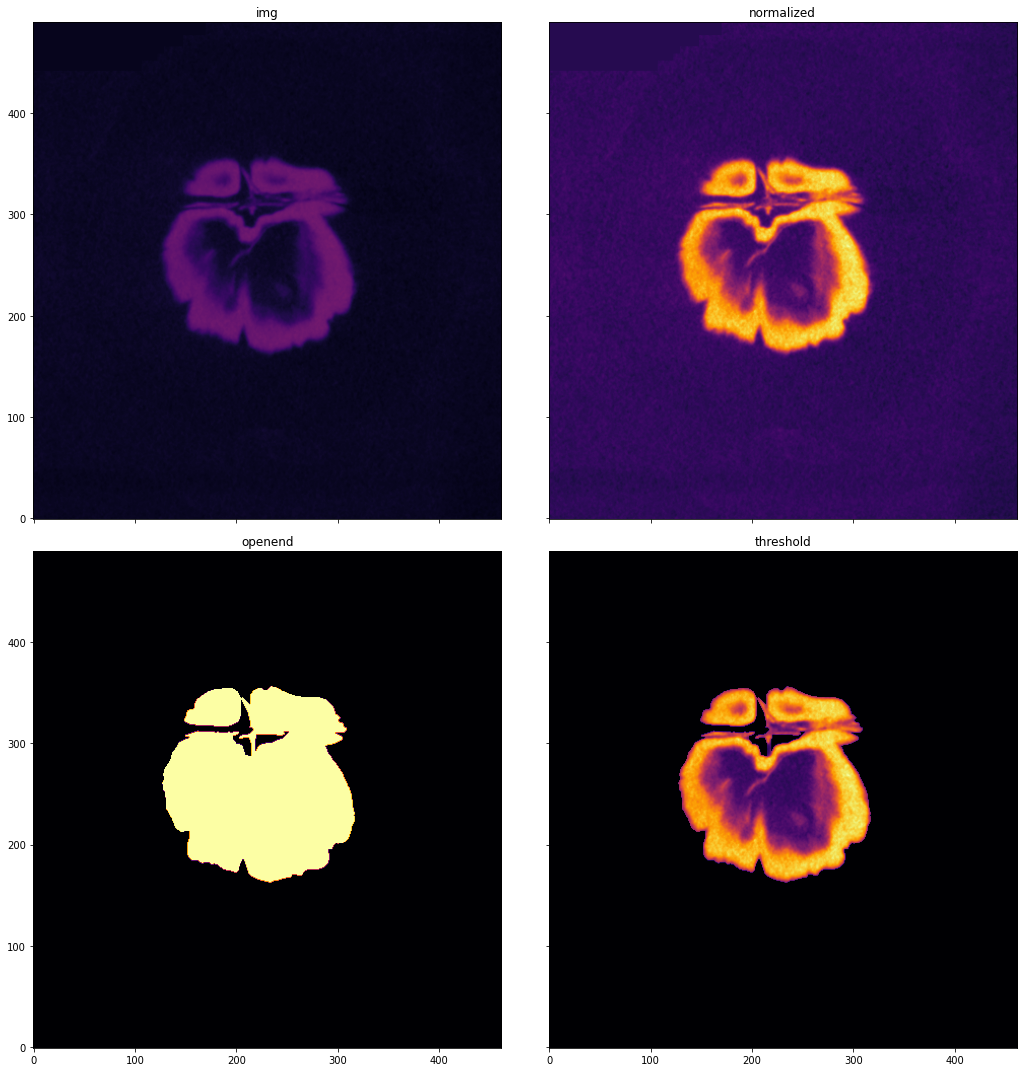

In [77]:
k = 510
ss = np.s_[k,:, :]
    
fig, ax = plt.subplots(2,2,figsize=(15,15), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('img')
i = 1
ax[i].imshow(aimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('normalized')
i = 2
ax[i].imshow(oimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
ax[i].set_title('openend')
i = 3
ax[i].imshow(cimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('threshold')

fig.tight_layout()

In [67]:
walnut, cero = clean_zeroes(cimg)
print(cimg.shape)
print(walnut.shape)

8 % reduction from input
(540, 490, 462)
(533, 470, 447)


In [82]:
cero

array([  8,   4,  14, 455, 537, 484])

In [68]:
filename = wdst + fname + '.tif'
print(filename)
tf.imwrite(filename, walnut, photometric='minisblack', compress=3)

../clean/SelectD_R9_T1/006.tif


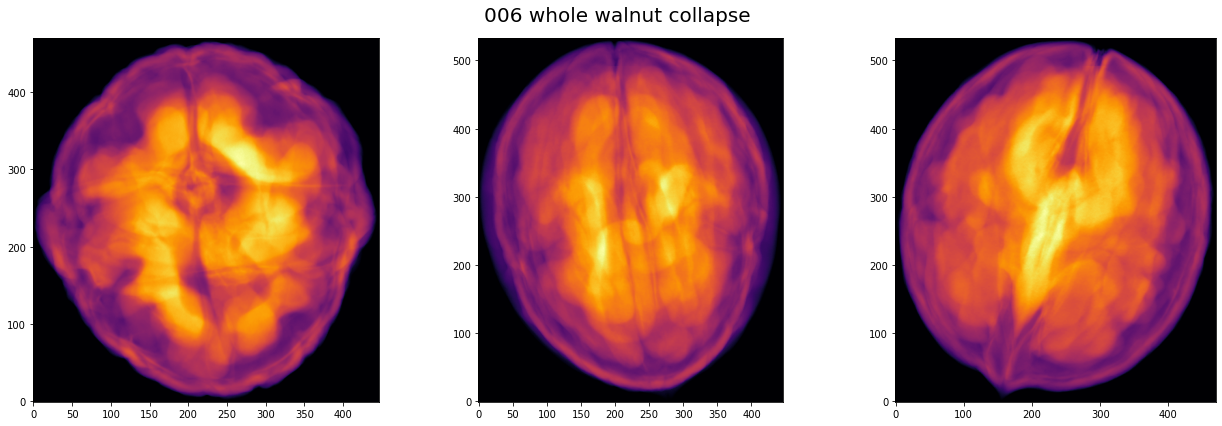

In [83]:
snaps = collapse_dimensions(walnut)
plot_collapse_dimensions(snaps, fname, 'whole walnut', dst=wdst)

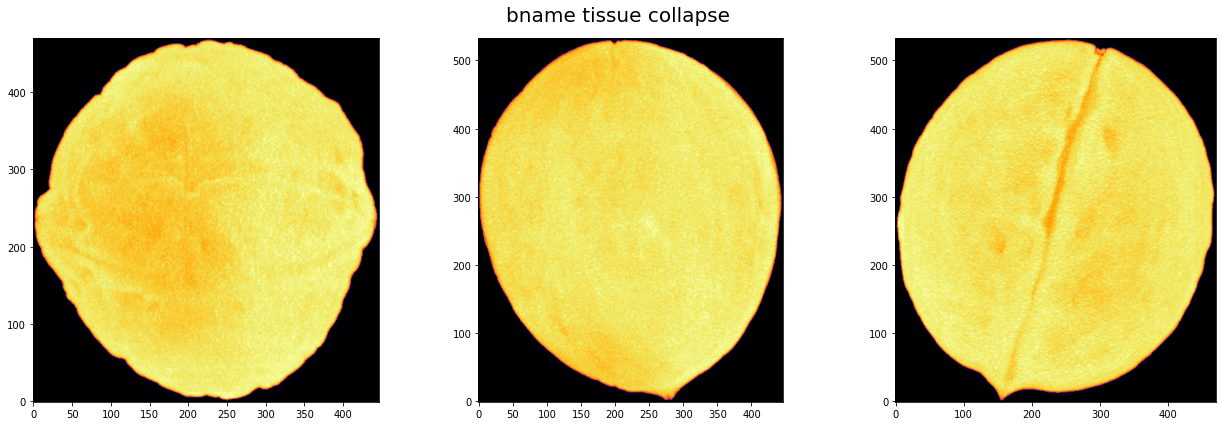

In [81]:
snaps = collapse_dimensions_max(walnut)
plot_collapse_dimensions(snaps)